<a href="https://colab.research.google.com/github/XMB234/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders
!pip install torch-summary

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preetviradiya/brian-tumor-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brian-tumor-dataset


In [ ]:
data = pd.read_csv(path + '/metadata.csv')
data.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [ ]:
data.shape

(4600, 6)

In [ ]:
import os
import pathlib
import splitfolders

# Tentukan path ke folder dataset
data_dir = pathlib.Path(path) / "Brain Tumor Data Set" / "Brain Tumor Data Set"

# Lihat isi folder (opsional, bisa dihapus kalau tidak diperlukan)
print("Isi folder data:", os.listdir(data_dir))

# Folder hasil split
output_dir = pathlib.Path("output")

# Split dataset menjadi train (80%) dan val (20%)
splitfolders.ratio(
    input=data_dir,
    output=output_dir,
    seed=1337,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Isi folder data: ['Brain Tumor', 'Healthy']


Copying files: 4600 files [00:27, 168.77 files/s]


In [ ]:
# Tampilkan path absolut folder output
print("Folder output disimpan di:", output_dir.resolve())

Folder output disimpan di: /content/output


In [ ]:
from torchvision import transforms

# Transformasi data (train): resize, augmentasi, konversi tensor, normalisasi
train_transform = transforms.Compose([
    transforms.Resize(224),  # Sama dengan (224, 224), karena square
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # Rata-rata channel RGB dari ImageNet
        std=[0.229, 0.224, 0.225]     # Std dev dari ImageNet
    )
])

#  Transformasi untuk val dan test (tanpa augmentasi)
test_val_transform =transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [ ]:
# Buat dataset
train_set = torchvision.datasets.ImageFolder(output_dir / "train", transform=train_transform)
val_set = torchvision.datasets.ImageFolder(output_dir / "val", transform=test_val_transform)
test_set = torchvision.datasets.ImageFolder(output_dir / "test", transform=test_val_transform)

In [ ]:
print("Label/class yang dikenali:", train_set.classes)

Label/class yang dikenali: ['Brain Tumor', 'Healthy']


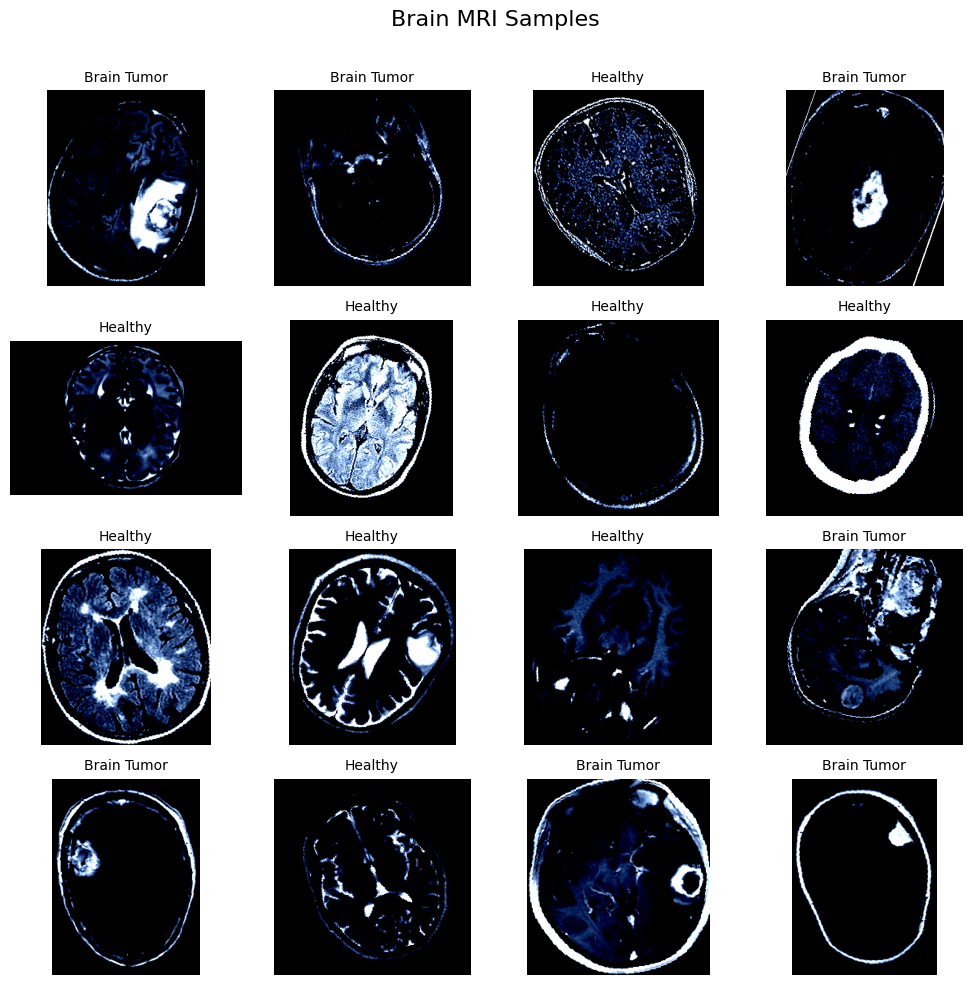

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ambil label dari train_set langsung, agar dinamis
class_labels = train_set.classes  # ['Brain Tumor', 'Healthy']

def imshow_tensor(img_tensor):
    """Convert tensor to NumPy image and handle normalization"""
    img_np = img_tensor.numpy().transpose((1, 2, 0))
    img_np = np.clip(img_np, 0, 1)  # Pastikan nilai dalam rentang valid
    return img_np

# Setup grid
cols, rows = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.suptitle("Brain MRI Samples", fontsize=16)

for i in range(rows * cols):
    idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[idx]
    ax = axes[i // cols, i % cols]
    ax.imshow(imshow_tensor(img))
    ax.set_title(class_labels[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Konfigurasi loader
batch_size = 32
num_workers = 2

# Custom collate function to handle images of different sizes
def custom_collate_fn(batch):
    # Assuming the images are of type torch.Tensor and labels are integers
    images = []
    labels = []
    for img, label in batch:
        # Resize the image to a consistent size (e.g., 224x224)
        if img.shape[1:] != (224, 224): # Check if resizing is needed
            # Use the same resize transform as in your dataset transforms
            resize_transform = transforms.Resize((224, 224))
            img = resize_transform(img)
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)


# Loader untuk train dan val
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate_fn)

# Fungsi untuk cek bentuk batch pertama
def inspect_loader(name, loader):
  X, y = next(iter(loader)) # Ambil 1 batch pertama
  print(f"{name}:")
  print(f" X.shape = {X.shape}, (dtype = {X.dtype})")
  print(f" y.shape = {y.shape}, (dtype = {y.dtype})\n")

# Cek isi folder
inspect_loader("Train Batch", train_loader)
inspect_loader("Val Batch", val_loader)

Train Batch:
 X.shape = torch.Size([32, 3, 224, 224]), (dtype = torch.float32)
 y.shape = torch.Size([32]), (dtype = torch.int64)

Val Batch:
 X.shape = torch.Size([32, 3, 224, 224]), (dtype = torch.float32)
 y.shape = torch.Size([32]), (dtype = torch.int64)



In [ ]:
def show_batch(X, y, class_labels, n=6):
  plt.figure(figsize=(12,2))
  for i in range(n):
    img = X[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.title(class_labels[y[i].item()])
    plt.axis("off")
  plt.show()

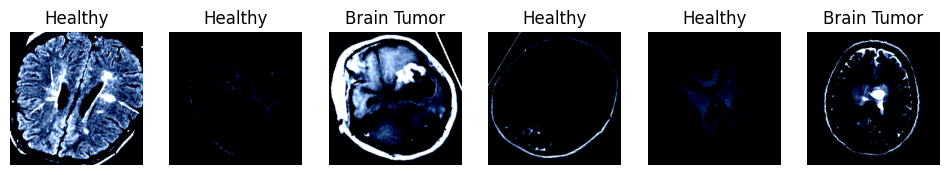

In [ ]:
X, y = next(iter(train_loader))
show_batch(X, y, train_set.classes)

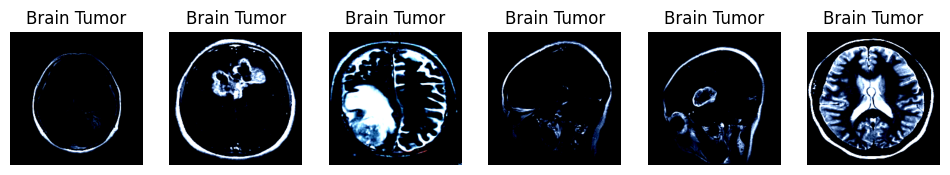

In [ ]:
X, y = next(iter(val_loader))
show_batch(X, y, val_set.classes)

In [ ]:
def get_conv2d_output_shape(h_in, w_in, conv_layer, pool_size=None):
    """
    Menghitung output shape (height, width) dari layer nn.Conv2d
    Args:
        h_in (int): tinggi input (height)
        w_in (int): lebar input (width)
        conv_layer (nn.Conv2d): layer konvolusi
        pool_size (int or None): ukuran pooling (misal 2 untuk MaxPool2d(kernel_size=2))

    Returns:
        (h_out, w_out): ukuran keluaran setelah konvolusi dan opsional pooling
    """
    kh, kw = conv_layer.kernel_size
    sh, sw = conv_layer.stride
    ph, pw = conv_layer.padding
    dh, dw = conv_layer.dilation

    h_out = ((h_in + 2* ph * (kh -1) -1) // sh) +1
    w_out = ((w_in + 2* pw * (kw -1) -1) // sw) +1

    if pool_size is not None:
        h_out //= pool_size
        w_out //= pool_size

    return h_out, w_out

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

h, w = 224, 224
out_h, out_w = get_conv2d_output_shape(h, w, conv1, pool_size=2)
print(f"Output shape setelah conv1 + pooling: {out_h} x {out_w}")

Output shape setelah conv1 + pooling: 114 x 114


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BrainTumor(nn.Module):
    def __init__(self, params):
        super(CNN_BrainTumor, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Feature Extractor (4 blok Conv+ReLU+MaxPool)
        self.features = nn.Sequential(
            nn.Conv2d(Cin, init_f, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(init_f, init_f * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(init_f * 2, init_f * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(init_f * 4, init_f * 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Adaptive pooling agar output feature map selalu fixed (contoh: 1x1 atau 2x2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # output shape: (C, 1, 1)

        # Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(init_f * 8 * 1 * 1, num_fc1),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(num_fc1, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [33]:
# Parameter model
params = {
    "shape_in": (3, 128, 128),
    "initial_filters": 32,
    "num_fc1": 128,
    "num_classes": 2,
    "dropout_rate": 0.3
}


# Deteksi perangkat keras (GPU > CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Buat model dan visualisasi
cnn_model = CNN_BrainTumor(params)

# (Opsional) Support multi-GPU jika tersedia
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    cnn_model = nn.DataParallel(cnn_model)

# Cek total parameter model (untuk diagnosa)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Trainable Parameters: {count_parameters(cnn_model):,}"